In [1]:
!which pip

/data/serrano/miniconda3/wisp/bin/pip


In [2]:
import airfrans as af
import matplotlib.pyplot as plt

In [3]:
PATH_TO_DATASET = "/data/serrano/airfrans/Dataset/"

In [4]:
import numpy as np

In [5]:
import torch

In [6]:
MIN_POS = torch.Tensor([-2.25, -1.65]).view(-1, 2)
MAX_POS = torch.Tensor([4.25, 1.65]).view(-1,2)

In [7]:
key_to_index = {
    "x": 0,
    "y": 1,
    "inlet_x": 2,
    "inlet_y": 3,
    "sdf": 4,
    "nx": 5,
    "ny": 6,
    "vx": 7,
    "vy": 8,
    "p": 9,
    "nu":10,
}

In [9]:
import torch_geometric

In [13]:
sample = torch_geometric.data.Data(pos=torch.rand(10, 2),  x=torch.randn(10, 1))
sample.y = 2*sample.x

In [14]:
new_sample = torch_geometric.data.Data(pos=torch.rand(10, 2))

In [18]:
newpos = new_sample.pos.requires_grad_()
print('newpos', newpos.std())
tt = torch_geometric.nn.unpool.knn_interpolate(sample.x, newpos, sample.pos)
loss = ((sample.y - tt)**2).mean()
grad = torch.autograd.grad(
            loss,
            newpos)[0]
newpos = newpos - 0.001*grad
print('newpos', newpos.std())

newpos tensor(0.2665, grad_fn=<StdBackward0>)


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

# 2. Try to fit a single image for each channel

In [7]:
import os
import sys
from pathlib import Path
sys.path.append("/home/serrano/Projects/INR_domain_decomposition/")

from src.data.dataset import GeometryDataset, KEY_TO_INDEX
from torch_geometric.loader import DataLoader

import einops
import json
import numpy as np
import torch
import torch.nn as nn
from graph_metalearning import outer_step

In [8]:
import yaml
from omegaconf import DictConfig

In [9]:
with open('../config/wisp_hash.yaml', 'r') as f:
    cfg = yaml.safe_load(f)
cfg = DictConfig(cfg)

In [10]:
data_dir = cfg.data.dir
task = cfg.data.task
data_to_encode = cfg.data.data_to_encode
score = cfg.data.score
ntrain = cfg.data.ntrain
ntest = cfg.data.ntest
seed = cfg.data.seed

In [11]:
data_to_encode = 'vx'

In [12]:
data_dir = '/data/serrano/airfrans/'
print('data_dir', data_dir)

# train
with open(Path(data_dir) / 'Dataset/manifest.json', 'r') as f:
    manifest = json.load(f)

manifest_train = manifest[task + '_train']
testset = manifest[task + '_test'] if task != 'scarce' else manifest['full_test']
n = int(.9*len(manifest_train))

print("len manifest train", manifest_train, n)

trainset = manifest_train[:20] # was [:-n] ???
valset = manifest_train[-20:]

ntrain = len(trainset)
nval = len(valset)

data_dir /data/serrano/airfrans/
len manifest train ['airFoil2D_SST_36.622_11.319_3.941_5.424_1.0_16.283', 'airFoil2D_SST_58.831_-3.563_2.815_4.916_10.078', 'airFoil2D_SST_43.327_8.905_4.236_6.511_10.744', 'airFoil2D_SST_89.151_4.462_0.974_4.094_1.0_19.856', 'airFoil2D_SST_87.422_2.992_1.895_3.128_1.0_10.656', 'airFoil2D_SST_42.531_-3.927_1.264_6.838_0.0_7.489', 'airFoil2D_SST_46.246_9.78_3.769_2.353_17.745', 'airFoil2D_SST_67.481_-1.259_5.136_2.438_18.882', 'airFoil2D_SST_45.701_-1.925_0.671_7.455_0.0_12.285', 'airFoil2D_SST_85.488_6.826_3.112_3.445_1.0_17.471', 'airFoil2D_SST_56.177_2.108_1.208_3.592_0.0_14.763', 'airFoil2D_SST_46.0_-0.095_2.322_1.874_16.58', 'airFoil2D_SST_81.846_10.688_0.402_4.721_0.0_11.955', 'airFoil2D_SST_56.749_1.468_1.967_7.293_1.0_8.866', 'airFoil2D_SST_41.403_-2.446_1.908_4.316_0.0_5.008', 'airFoil2D_SST_44.858_13.36_1.546_3.174_1.0_10.604', 'airFoil2D_SST_71.85_7.865_2.88_6.646_0.0_18.137', 'airFoil2D_SST_90.26_10.644_0.076_3.962_1.0_18.874', 'airFoil2D_SST

In [13]:
#default sample is none
latent_dim = 128
batch_size = 16
trainset = GeometryDataset(trainset, key=data_to_encode, latent_dim=latent_dim, norm=True, sample='uniform', n_boot=16000)
print("loaded train")
valset = GeometryDataset(valset, key=data_to_encode, latent_dim=latent_dim, sample='uniform', n_boot=16000, coef_norm=trainset.coef_norm)

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
# test
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=True)
device = torch.device("cuda")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.29it/s]


coef_norm (array([1.0039341e+00, 1.3867494e-03, 6.0501919e+01, 4.6542292e+00,
       1.5239350e+00, 0.0000000e+00, 0.0000000e+00], dtype=float32), array([ 1.7257376 ,  0.859238  , 17.44468   ,  5.7680225 ,  0.8693063 ,
        0.0625397 ,  0.29492253], dtype=float32), array([ 6.0471752e+01,  4.4364605e+00, -9.7095356e+00,  1.4119358e-04],
      dtype=float32), array([2.4853756e+01, 6.1149659e+00, 5.6535822e+02, 1.2463701e-03],
      dtype=float32))
loaded train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.18it/s]

coef_norm (array([1.0039341e+00, 1.3867494e-03, 6.0501919e+01, 4.6542292e+00,
       1.5239350e+00, 0.0000000e+00, 0.0000000e+00], dtype=float32), array([ 1.7257376 ,  0.859238  , 17.44468   ,  5.7680225 ,  0.8693063 ,
        0.0625397 ,  0.29492253], dtype=float32), array([ 6.0471752e+01,  4.4364605e+00, -9.7095356e+00,  1.4119358e-04],
      dtype=float32), array([2.4853756e+01, 6.1149659e+00, 5.6535822e+02, 1.2463701e-03],
      dtype=float32))


In [14]:
import wisp

In [15]:
from wisp.accelstructs import OctreeAS
from wisp.models.decoders.basic_decoders import BasicDecoder
from wisp.models.grids import BLASGrid, OctreeGrid, CodebookOctreeGrid, TriplanarGrid, HashGrid
from wisp.tracers import BaseTracer, PackedSDFTracer
from wisp.models.nefs import BaseNeuralField, NeuralSDF
from wisp.models.pipeline import Pipeline
from wisp.trainers import BaseTrainer, SDFTrainer

In [16]:
# Copyright (c) 2022, NVIDIA CORPORATION & AFFILIATES.  All rights reserved.
#
# NVIDIA CORPORATION & AFFILIATES and its licensors retain all intellectual property
# and proprietary rights in and to this software, related documentation
# and any modifications thereto.  Any use, reproduction, disclosure or
# distribution of this software and related documentation without an express
# license agreement from NVIDIA CORPORATION & AFFILIATES is strictly prohibited.

import torch
from typing import Dict, Any

from wisp.models.nefs import BaseNeuralField
from wisp.models.embedders import get_positional_embedder
from wisp.models.layers import get_layer_class
from wisp.models.activations import get_activation_class
from wisp.models.decoders import BasicDecoder
from wisp.models.grids import BLASGrid


class MyNeuralField(BaseNeuralField):
    """Model for encoding neural signed distance functions (implicit surfaces).
    This field implementation uses feature grids for faster and more efficient queries.
    For example, the usage of Octree follows the idea from Takikawa et al. 2021 (Neural Geometric Level of Detail).
    """
    def __init__(self,
                 grid: BLASGrid = None,
                 # embedder args
                 pos_embedder: str = 'none',
                 pos_multires: int = 10,
                 position_input: bool = True,
                 # decoder args
                 activation_type: str = 'relu',
                 layer_type: str = 'none',
                 hidden_dim: int = 128,
                 num_layers: int = 1
                 ):
        """
        Creates a new neural field of an implicit furface, which maps 3D input coordinates to SDF values.

        This neural field consists of:
         * A feature grid (backed by an acceleration structure to boost raymarching speed)
         * SDF decoder
         * Optional: positional embedders for input position coords, concatenated to grid features.

         This neural field also supports:
          * Aggregation of multi-resolution features (more than one LOD) via summation or concatenation

        Args:
            grid: (BLASGrid): represents feature grids in Wisp. BLAS: "Bottom Level Acceleration Structure",
                to signify this structure is the backbone that captures
                a neural field's contents, in terms of both features and occupancy for speeding up queries.
                Notable examples: OctreeGrid, HashGrid, TriplanarGrid.

            pos_embedder (str): Type of positional embedder to use for input coordinates.
                Options:
                 - 'none': No positional input is fed into the SDF decoder.
                 - 'identity': The sample coordinates are fed as is into the SDF decoder.
                 - 'positional': The sample coordinates are embedded with the Positional Encoding from
                    Mildenhall et al. 2020, before passing them into the SDF decoder.
            pos_multires (int): Number of frequencies used for 'positional' embedding of pos_embedder.
                 Used only if pos_embedder is 'positional'.
            position_input (bool): If True, the input coordinates will be passed into the decoder.
                 For 'positional': the input coordinates will be concatenated to the embedded coords.
                 For 'none' and 'identity': the embedder will behave like 'identity'.
            activation_type (str): Type of activation function to use in BasicDecoder:
                 'none', 'relu', 'sin', 'fullsort', 'minmax'.
            layer_type (str): Type of MLP layer to use in BasicDecoder:
                 'none' / 'linear', 'spectral_norm', 'frobenius_norm', 'l_1_norm', 'l_inf_norm'.
            hidden_dim (int): Number of neurons in hidden layers of SDF decoder.
            num_layers (int): Number of hidden layers in SDF decoder.
        """
        super().__init__()
        self.grid = grid

        # Init Embedders
        self.pos_multires = pos_multires
        self.position_input = position_input
        self.pos_embedder, self.pos_embed_dim = self.init_embedder(pos_embedder, pos_multires, position_input)

        # Init Decoder
        self.activation_type = activation_type
        self.layer_type = layer_type
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.decoder = self.init_decoder(activation_type, layer_type, num_layers, hidden_dim)

        torch.cuda.empty_cache()

    def init_embedder(self, embedder_type, frequencies=None, position_input=True):
        """Creates positional embedding functions for the position and view direction.
        """
        if embedder_type == 'none' and not position_input:
            embedder, embed_dim = None, 0
        elif embedder_type == 'identity' or (embedder_type == 'none' and position_input):
            embedder, embed_dim = torch.nn.Identity(), 2
        elif embedder_type == 'positional':
            embedder, embed_dim = get_positional_embedder(frequencies=frequencies, input_dim= 2, include_input=position_input)
        else:
            raise NotImplementedError(f'Unsupported embedder type for NeuralSDF: {embedder_type}')
            
        return embedder, embed_dim

    def init_decoder(self, activation_type, layer_type, num_layers, hidden_dim):
        """Initializes the decoder object.
        """
        decoder = BasicDecoder(input_dim=self.decoder_input_dim(),
                               output_dim=1,
                               activation=get_activation_class(activation_type),
                               bias=True,
                               layer=get_layer_class(layer_type),
                               num_layers=num_layers,
                               hidden_dim=hidden_dim,
                               skip=[])
        return decoder

    def register_forward_functions(self):
        """Register the forward functions.
        """
        self._register_forward_function(self.velocity, ["velocity"])

    def velocity(self, coords, lod_idx=None):
        """Computes the Signed Distance Function for input samples.

        Args:
            coords (torch.FloatTensor): tensor of shape [batch, num_samples, 3]
            lod_idx (int): index into active_lods. If None, will use the maximum LOD.
        
        Outputs:
            (torch.FloatTensor):
            - SDF of shape [batch, num_samples, 1]
        """
        shape = coords.shape
        
        if shape[0] == 0:
            return dict(sdf=torch.zeros_like(coords)[...,0:1])

        if lod_idx is None:
            lod_idx = self.grid.num_lods - 1

        if len(shape) == 2:
            coords = coords[:, None]
        num_samples = coords.shape[1]

        feats = self.grid.interpolate(coords, lod_idx)

        # Optionally concat the positions to the embedding
        if self.pos_embedder is not None:
            #print("pos embedder", self.pos_embedder)
            #print('coords', coords.shape)
            #print('pos_embed_dim', self.pos_embed_dim)
            feats = torch.cat([self.pos_embedder(coords[..., :2].view(-1, 2)).view(-1, num_samples, self.pos_embed_dim), 
                               feats], dim=-1)

        out = self.decoder(feats)

        if len(shape) == 2:
            out = out[:,0]
            
        return out

    def effective_feature_dim(self):
        if self.grid.multiscale_type == 'cat':
            effective_feature_dim = self.grid.feature_dim * self.grid.num_lods
        else:
            effective_feature_dim = self.grid.feature_dim
            
        if self.pos_embedder is not None:
            effective_feature_dim += self.pos_embed_dim
            
        return effective_feature_dim

    def decoder_input_dim(self):
        input_dim = self.effective_feature_dim()
        
        if self.position_input:
            input_dim += self.pos_embed_dim
        
        return input_dim

    def public_properties(self) -> Dict[str, Any]:
        """ Wisp modules expose their public properties in a dictionary.
        The purpose of this method is to give an easy table of outwards facing attributes,
        for the purpose of logging, gui apps, etc.
        """
        properties = {
            "Grid": self.grid,
            "Pos. Embedding": self.pos_embedder,
            "Decoder (sdf)": self.decoder,
        }
        return properties

In [17]:
nef = load_neural_field(wisp_cfg)
nef = nef.cuda()

NameError: name 'load_neural_field' is not defined

In [ ]:
pred = nef.velocity(coords_sub)

In [ ]:
def load_grid(args) -> BLASGrid:
    """Loads the hierarchical feature grid to use within the neural sdf pipeline.
    Grid choices are interesting to explore, so we leave the exact backbone type configurable,
    and show how grid instances may be explicitly constructed.
    Grids choices, for example, are: OctreeGrid, TriplanarGrid, HashGrid
    See corresponding grid constructors for each of their arg details.
    """
    grid = None
    if args.grid_type == "OctreeGrid":
        # For SDF pipelines case, the grid may be initialized from the mesh to speed up the optimization.
        grid = OctreeGrid.from_mesh(
            mesh_path=args.dataset_path,
            num_samples_on_mesh=args.num_samples_on_mesh,
            feature_dim=args.feature_dim,
            base_lod=args.base_lod,
            num_lods=args.num_lods,
            interpolation_type=args.interpolation_type,
            multiscale_type=args.multiscale_type,
            feature_std=args.feature_std,
            feature_bias=args.feature_bias,
        )
    elif args.grid_type == "TriplanarGrid":
        grid = TriplanarGrid(
            feature_dim=args.feature_dim,
            base_lod=args.base_lod,
            num_lods=args.num_lods,
            interpolation_type=args.interpolation_type,
            multiscale_type=args.multiscale_type,
            feature_std=args.feature_std,
            feature_bias=args.feature_bias,
        )
        
    elif args.grid_type == "CodebookOctreeGrid":
        # try with pointcloud to see what changes
        
        #if dataset.supports_depth:
        #    grid = CodebookOctreeGrid.from_pointcloud(
        #        pointcloud=dataset.as_pointcloud(),
        #        feature_dim=args.feature_dim,
        #        base_lod=args.base_lod,
        #        num_lods=args.num_lods,
        #        interpolation_type=args.interpolation_type,
        #        multiscale_type=args.multiscale_type,
        #        feature_std=args.feature_std,
        #        feature_bias=args.feature_bias,
        #        codebook_bitwidth=args.codebook_bitwidth
        #    )
        grid = CodebookOctreeGrid.make_dense(
            feature_dim=args.feature_dim,
            base_lod=args.base_lod,
            num_lods=args.num_lods,
            interpolation_type=args.interpolation_type,
            multiscale_type=args.multiscale_type,
            feature_std=args.feature_std,
            feature_bias=args.feature_bias,
            codebook_bitwidth=args.codebook_bitwidth
        )
    elif args.grid_type == "HashGrid":
        # "geometric" - determines the resolution of the grid using geometric sequence initialization from InstantNGP,
        if args.tree_type == "geometric":
            grid = HashGrid.from_geometric(
                feature_dim=args.feature_dim,
                num_lods=args.num_lods,
                multiscale_type=args.multiscale_type,
                feature_std=args.feature_std,
                feature_bias=args.feature_bias,
                codebook_bitwidth=args.codebook_bitwidth,
                min_grid_res=args.min_grid_res,
                max_grid_res=args.max_grid_res,
                blas_level=args.blas_level
            )
        # "quad" - determines the resolution of the grid using an octree sampling pattern.
        elif args.tree_type == "octree":
            grid = HashGrid.from_octree(
                feature_dim=args.feature_dim,
                base_lod=args.base_lod,
                num_lods=args.num_lods,
                multiscale_type=args.multiscale_type,
                feature_std=args.feature_std,
                feature_bias=args.feature_bias,
                codebook_bitwidth=args.codebook_bitwidth,
                blas_level=args.blas_level
            )
    else:
        raise ValueError(f"Unknown grid_type argument: {args.grid_type}")
    return grid

In [ ]:
def load_neural_field(args) -> BaseNeuralField:
    """ Creates a "Neural Field" instance which converts input coordinates to some output signal.
    Here a NeuralSDF is created, which maps 3D coordinates -> SDF values.
    NeuralSDF is a combo of a spatial feature grid and a single decoder.
    The NeuralSDF uses the grid internally for faster feature interpolation and raytracing.
    """
    grid = load_grid(args=args.grid)
    
    nef = MyNeuralField(
        grid=grid,
        pos_embedder=wisp_cfg.nef.pos_embedder,
        pos_multires=wisp_cfg.nef.pos_multires,
        position_input=wisp_cfg.nef.position_input,
        activation_type=wisp_cfg.nef.activation_type,
        layer_type=wisp_cfg.nef.layer_type,
        hidden_dim=wisp_cfg.nef.hidden_dim,
        num_layers=wisp_cfg.nef.num_layers
    )
    return nef

In [37]:
with open('../config/wisp_codebook.yaml', 'r') as f:
    wisp_cfg = yaml.safe_load(f)
wisp_cfg = DictConfig(wisp_cfg)

In [38]:
#wisp_cfg.grid.blas_level=7
#wisp_cfg.grid.multiscale_type="sum"
#wisp_cfg.nef.pos_multires=4
#wisp_cfg.nef.activation_type = "relu"
#wisp_cfg.nef.layer_type = "none"
#wisp_cfg.optimizer.weight_decay=0

In [39]:
wisp_cfg

{'data': {'dir': '/data/serrano/airfrans/', 'data_to_encode': 'vx', 'sample': 'mesh', 'task': 'full', 'score': 0, 'ntrain': None, 'ntest': None, 'seed': 123}, 'logging': {'exp_name': 'test-nglod-sdf'}, 'dataset': {'num_samples': 500000, 'samples_per_voxel': 32}, 'nef': {'hidden_dim': 64, 'num_layers': 2, 'pos_embedder': 'none', 'position_input': True, 'pos_multires': 4, 'layer_type': 'none', 'activation_type': 'relu'}, 'optimizer': {'optimizer_type': 'adam', 'eps': 1e-15, 'lr': 0.01, 'grid_lr_weight': 1.0, 'weight_decay': 0}, 'trainer': {'epochs': 10, 'batch_size': 512, 'model_format': 'full', 'valid_every': 10, 'save_every': 5, 'render_tb_every': 5, 'log_2d': True, 'only_last': True, 'resample': True}, 'tracer': {'num_steps': 32, 'step_size': 0.8}, 'renderer': {'render_batch': 0, 'camera_origin': [-2.8, 2.3, -2.8], 'shading_mode': 'matcap', 'render_res': [1024, 1024], 'shadow': True}, 'grid': {'grid_type': 'CodebookOctreeGrid', 'interpolation_type': 'linear', 'multiscale_type': 'cat',

In [40]:
nef = load_neural_field(wisp_cfg).cuda()

In [41]:
len(nef.grid.active_lods)

1

In [45]:
def init_optimizer(nef, cfg):
    """Default initialization for the optimizer.
    """

    params_dict = { name : param for name, param in nef.named_parameters()}

    params = []
    decoder_params = []
    grid_params = []
    rest_params = []

    for name in params_dict:

        if 'decoder' in name:
            # If "decoder" is in the name, there's a good chance it is in fact a decoder,
            # so use weight_decay
            decoder_params.append(params_dict[name])

        elif 'grid' in name:
            # If "grid" is in the name, there's a good chance it is in fact a grid,
            # so use grid_lr_weight
            grid_params.append(params_dict[name])

        else:
            rest_params.append(params_dict[name])

    params.append({"params" : decoder_params,
                   "lr": cfg.lr, 
                   "weight_decay": cfg.weight_decay})

    params.append({"params" : grid_params,
                   "lr": cfg.lr * cfg.grid_lr_weight})

    params.append({"params" : rest_params,
                   "lr": cfg.lr})

    #optimizer = torch.optim.Adam(params, **cfg.optim_params)
    optimizer = torch.optim.Adam(params)
    
    return optimizer

In [46]:
optimizer = init_optimizer(nef, wisp_cfg.optimizer)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode='min', factor=0.5,
                                                       patience=500,
                                                       threshold=0.001,
                                                       threshold_mode='rel', cooldown=0, min_lr=1e-4, eps=1e-08, verbose=False)

In [48]:
for graph, idx in train_loader:
    break

In [49]:
index = 0
mask = graph.batch == index

In [50]:
gamma = 5
coordinates = graph.pos[mask]
max_ = coordinates.max(0)[0]
min_ = coordinates.min(0)[0]

# rescale in -1, 1
coordinates = (coordinates - min_)/(max_ - min_) * 2 - 1

# stack z = 0
coordinates = torch.cat([coordinates, torch.zeros(coordinates.shape[0], 1)], axis=-1).cuda()

# scale images
images = graph.images[mask].cuda()
images_scaled = images/gamma 

In [51]:
epochs=10000
for step in range(epochs):
    pred = nef.velocity(coordinates)
    loss = ((pred - images_scaled)**2).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step(loss)

    if step % 100 == 0:
        print(f"loss: {((pred*gamma - images)**2).mean()}")

loss: 0.7950882315635681
loss: 0.021457454189658165
loss: 0.010349476709961891
loss: 0.011384140700101852
loss: 0.01264135167002678
loss: 0.0057286606170237064
loss: 0.005046728998422623
loss: 0.004022413399070501
loss: 0.003421213012188673
loss: 0.004049747716635466
loss: 0.00367454020306468
loss: 0.002990282140672207
loss: 0.003104835981503129
loss: 0.002841838402673602
loss: 0.0033142431639134884
loss: 0.005122485104948282
loss: 0.0032267672941088676
loss: 0.0022023816127330065
loss: 0.0022469901014119387
loss: 0.0020077251829206944
loss: 0.0017477086512371898
loss: 0.09010148793458939
loss: 0.004579517059028149
loss: 0.006420886144042015
loss: 0.00846104696393013
loss: 0.004789487924426794
loss: 0.0032399436458945274
loss: 0.003701596288010478
loss: 0.0027370445895940065
loss: 0.005181415937840939
loss: 0.0025229633320122957
loss: 0.0022564504761248827
loss: 0.002035648562014103
loss: 0.0018714137841016054
loss: 0.0021545931231230497
loss: 0.0020201285369694233
loss: 0.001988895935

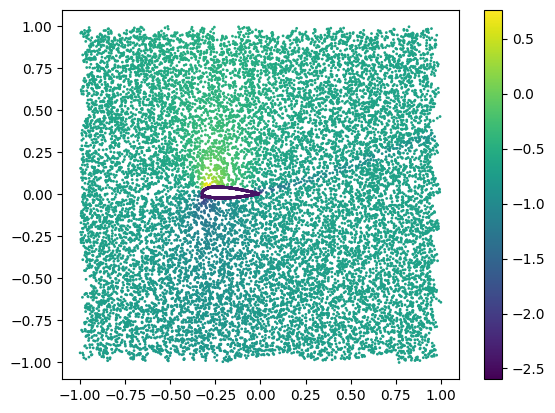

In [52]:
plt.scatter(coordinates[..., 0].detach().cpu(), coordinates[..., 1].detach().cpu(), c=images.cpu().detach(), s=1)
plt.colorbar()

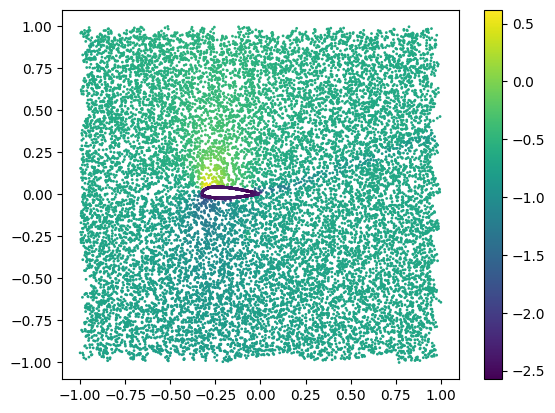

In [53]:
plt.scatter(coordinates[..., 0].detach().cpu(), coordinates[..., 1].detach().cpu(), c=gamma*pred.cpu().detach(), s=1)
plt.colorbar()

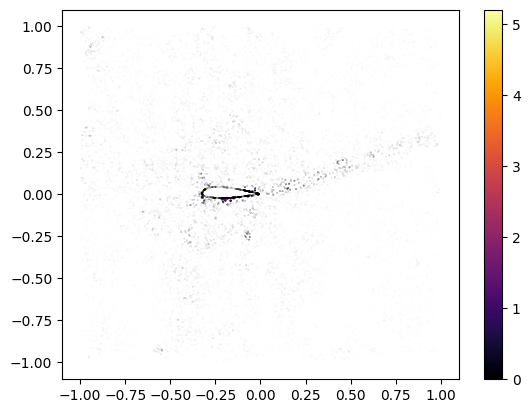

In [54]:
diff = ((gamma*pred - images)**2).cpu().detach()
plt.scatter(coordinates[..., 0].detach().cpu(), coordinates[..., 1].detach().cpu(), s=diff, c=diff, cmap='inferno')
plt.colorbar()

# 3. With mesh sampling

In [57]:
trainset = manifest_train[:20] # was [:-n] ???
valset = manifest_train[-20:]

In [58]:
#default sample is none
trainset2 = GeometryDataset(trainset, key=data_to_encode, latent_dim=latent_dim, norm=True, sample=None, n_boot=16000)
print("loaded train")
valset2 = GeometryDataset(valset, key=data_to_encode, latent_dim=latent_dim, sample=None, n_boot=16000, coef_norm=trainset2.coef_norm)

train_loader2 = DataLoader(trainset2, batch_size=batch_size, shuffle=True)
# test
val_loader2 = DataLoader(valset2, batch_size=batch_size, shuffle=True)
device = torch.device("cuda")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.69it/s]


coef_norm (array([ 5.00952303e-01,  1.13321105e-02,  6.05853500e+01,  4.67220497e+00,
        2.31252700e-01, -1.67829567e-03, -8.47164993e-05], dtype=float32), array([ 0.70306975,  0.33679357, 17.544584  ,  5.7692056 ,  0.47445256,
        0.04213712,  0.06204045], dtype=float32), array([ 4.1554970e+01,  8.7277184e+00, -2.4333244e+02,  7.6442689e-04],
      dtype=float32), array([2.8129255e+01, 2.6411243e+01, 1.8448706e+03, 2.5445439e-03],
      dtype=float32))
loaded train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.92it/s]

coef_norm (array([ 5.00952303e-01,  1.13321105e-02,  6.05853500e+01,  4.67220497e+00,
        2.31252700e-01, -1.67829567e-03, -8.47164993e-05], dtype=float32), array([ 0.70306975,  0.33679357, 17.544584  ,  5.7692056 ,  0.47445256,
        0.04213712,  0.06204045], dtype=float32), array([ 4.1554970e+01,  8.7277184e+00, -2.4333244e+02,  7.6442689e-04],
      dtype=float32), array([2.8129255e+01, 2.6411243e+01, 1.8448706e+03, 2.5445439e-03],
      dtype=float32))


In [315]:
with open('../config/wisp_hash.yaml', 'r') as f:
    wisp_cfg = yaml.safe_load(f)
wisp_cfg = DictConfig(wisp_cfg)

In [316]:
#wisp_cfg.nef.pos_embedder = 'positional'

In [317]:
torch.cuda.empty_cache()

In [333]:
nef = load_neural_field(wisp_cfg).cuda()

In [334]:
wisp_cfg.optimizer.weight_decay = float(wisp_cfg.optimizer.weight_decay)
optimizer = init_optimizer(nef, wisp_cfg.optimizer)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode='min', factor=0.5,
                                                       patience=500,
                                                       threshold=0.001,
                                                       threshold_mode='rel', cooldown=0, min_lr=1e-5, eps=1e-08, verbose=False)

In [320]:
for graph, idx in train_loader2:
    break

In [321]:
index = 0
mask = graph.batch == index

In [322]:
gamma = 1
coordinates = graph.pos[mask]
max_ = coordinates.max(0)[0]
min_ = coordinates.min(0)[0]

# rescale in -1, 1
coordinates = (coordinates - min_)/(max_ - min_) * 2 - 1

# stack z = 0
coordinates = torch.cat([coordinates, torch.zeros(coordinates.shape[0], 1)], axis=-1).cuda()

# scale images
images = graph.images[mask].cuda()
images_scaled = images/gamma 

In [323]:
# subsampling
coords_sub = coordinates[::10]
images_sub = images_scaled[::10]

In [324]:
images.std()

tensor(0.7330, device='cuda:0')

In [325]:
optimizer.zero_grad()

In [335]:
epochs=100000
for step in range(epochs):
    pred = nef.velocity(coords_sub)
    loss = ((pred - images_sub)**2).mean()
    optimizer.zero_grad()
    with torch.cuda.nvtx.range("SDFTrainer.backward"):
        loss.backward()
        optimizer.step()
    scheduler.step(loss)

    if step % 100 == 0:
        print(f"loss: {((gamma*(pred - images_sub))**2).mean()}")

loss: 0.580460786819458
loss: 0.11282267421483994
loss: 0.08418040722608566
loss: 0.08032400906085968
loss: 0.07088903337717056
loss: 0.07454290241003036
loss: 0.06733275204896927
loss: 0.06032600998878479
loss: 0.059070974588394165
loss: 0.06186547502875328
loss: 0.0633399486541748
loss: 0.04963596910238266
loss: 0.0488988496363163
loss: 0.0760837122797966
loss: 0.0475865863263607
loss: 0.04538597911596298
loss: 0.05410057678818703
loss: 0.06113990768790245
loss: 0.04270714521408081
loss: 0.062209635972976685
loss: 0.050245799124240875
loss: 0.04813380911946297
loss: 0.0482683964073658
loss: 0.06347087025642395
loss: 0.04212780296802521
loss: 0.04068872332572937
loss: 0.03930644690990448
loss: 0.03827957808971405
loss: 0.0414949394762516
loss: 0.051893994212150574
loss: 0.0405677892267704
loss: 0.03533272072672844
loss: 0.05496115982532501
loss: 0.044298235327005386
loss: 0.04885118082165718
loss: 0.03966083377599716
loss: 0.039411477744579315
loss: 0.04066811501979828
loss: 0.0339046

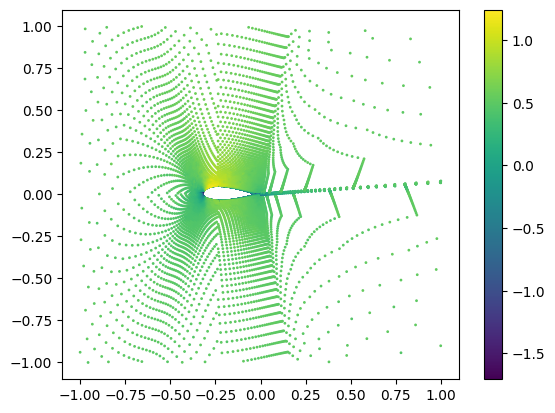

In [336]:
plt.scatter(coords_sub[..., 0].detach().cpu(), coords_sub[..., 1].detach().cpu(), c=gamma*pred.detach().cpu(), s=1)
plt.colorbar()

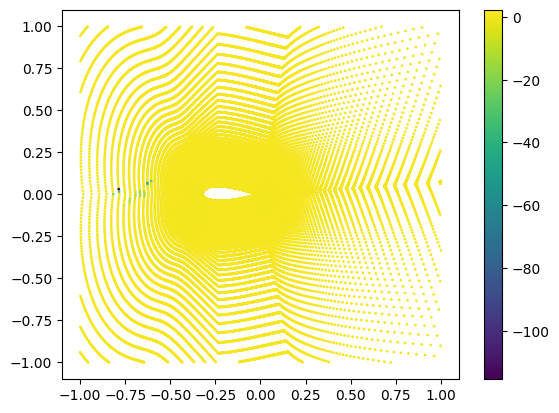

In [338]:
nef.eval()
pred = nef.velocity(coordinates)
plt.scatter(coordinates[..., 0].detach().cpu(), coordinates[..., 1].detach().cpu(), c=gamma*pred.detach().cpu(), s=1)
plt.colorbar()

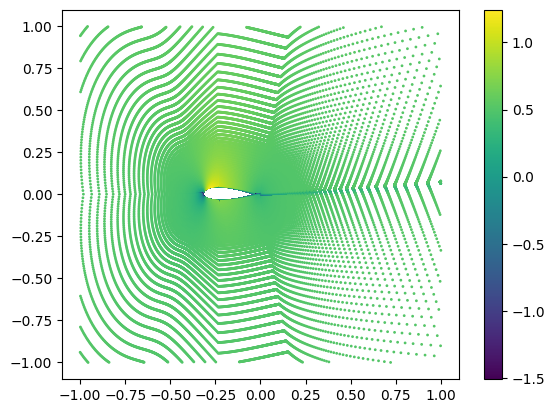

In [339]:
plt.scatter(coordinates[..., 0].detach().cpu(), coordinates[..., 1].detach().cpu(), c=images.detach().cpu(), s=1)
plt.colorbar()

In [340]:
loss = ((images - pred)**2).mean()

In [341]:
loss

tensor(0.1227, device='cuda:0', grad_fn=<MeanBackward0>)

In [321]:
w0 = 30
inr = Siren(dim_in=2,
            dim_hidden=256,
            dim_out=1,
            num_layers=5,
            w0=w0,
            w0_initial=w0,
            use_bias=True,
        ).cuda()

In [322]:
optimizer = torch.optim.Adam(inr.parameters(), lr=1e-4)

In [323]:
x_mask = (coordinates[..., 0] < 0.6) & (coordinates[..., 0] > 0.4)
y_mask = (coordinates[..., 1] < 0.6) & (coordinates[..., 1] > 0.4)
mask = x_mask & y_mask

In [324]:
coords_sub = (coordinates[mask] - 0.4)*100
images_sub = images_scaled[mask]

In [325]:
epochs=10000
for step in range(epochs):
    pred = inr(coords_sub)
    loss = ((pred - images_sub)**2).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if step % 200 == 0:
        print(f"loss: {((gamma*(pred - images_sub))**2).mean()}")

loss: 1.034475564956665
loss: 0.013061603531241417
loss: 0.007928073406219482
loss: 0.004260915331542492
loss: 0.0032179937697947025
loss: 0.0033631008118391037
loss: 0.0023756169248372316
loss: 0.0017124955775216222
loss: 0.0019903641659766436
loss: 0.002891495358198881
loss: 0.0009753579506650567
loss: 0.0012166238157078624
loss: 0.0012091930257156491
loss: 0.001270992448553443
loss: 0.0014312054263427854
loss: 0.0009011279908008873
loss: 0.0018298239447176456
loss: 0.0017821554793044925
loss: 0.0006422006990760565
loss: 0.0006973950075916946
loss: 0.0013524823589250445
loss: 0.00138726772274822
loss: 0.0014934593345969915
loss: 0.0012435703538358212
loss: 0.0017909595044329762
loss: 0.0014233742840588093
loss: 0.0013678964460268617
loss: 0.0006341334083117545
loss: 0.0009100615861825645
loss: 0.000862468674313277
loss: 0.0013830516254529357
loss: 0.0015914434334263206
loss: 0.0013916543684899807
loss: 0.00035944324918091297
loss: 0.0005034864880144596
loss: 0.0008461619727313519
los

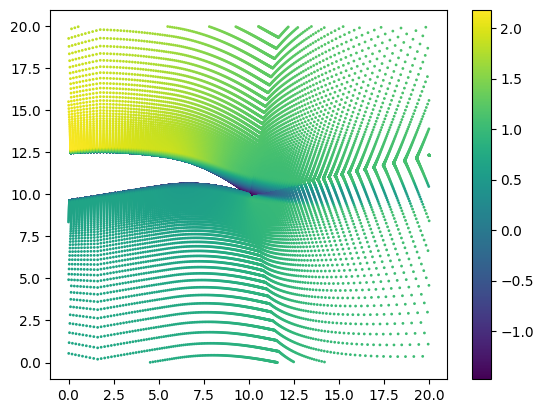

In [326]:
plt.scatter(coords_sub[..., 0].detach().cpu(), coords_sub[..., 1].detach().cpu(), c=gamma*images_sub.detach().cpu(), s=1)
plt.colorbar()

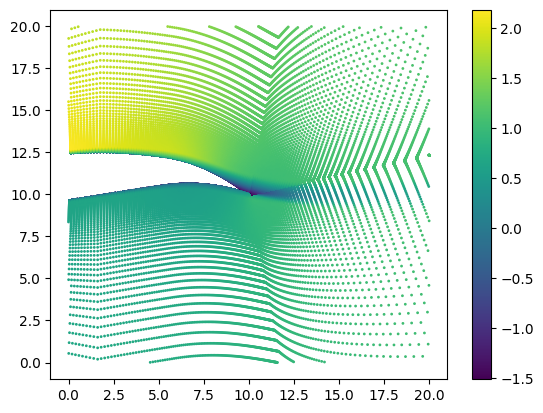

In [327]:
plt.scatter(coords_sub[..., 0].detach().cpu(), coords_sub[..., 1].detach().cpu(), c=gamma*pred.detach().cpu(), s=1)
plt.colorbar()

In [ ]:
coord_plt

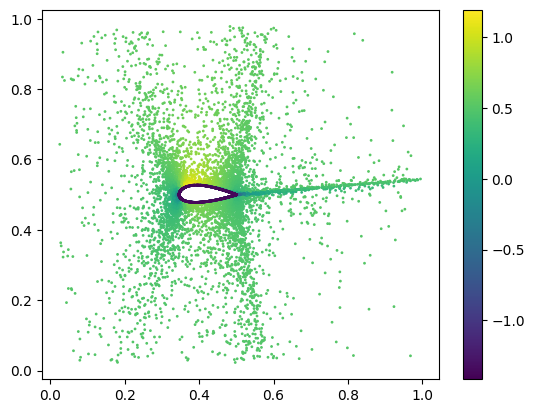

In [128]:
img_plt = images.detach().cpu()
pred_plt = pred.detach().cpu()
coord_plt = coordinates.detach().cpu()
plt.scatter(coord_plt[..., 0], coord_plt[..., 1], c=img_plt, s=1)
plt.colorbar()

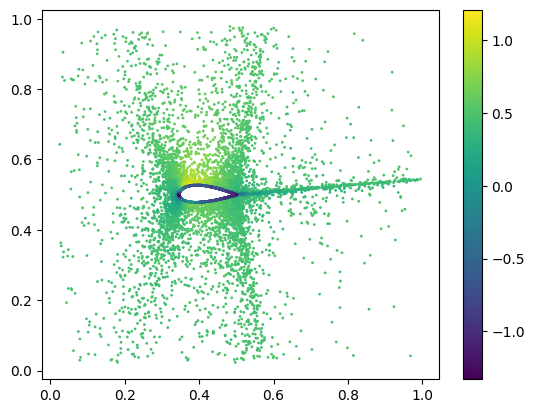

In [129]:
plt.scatter(coord_plt[..., 0], coord_plt[..., 1], c=pred_plt*gamma, s=1)
plt.colorbar()

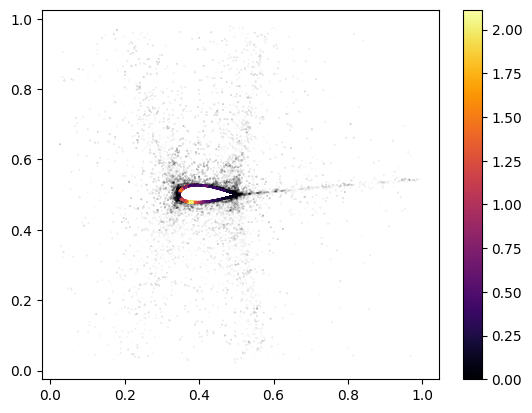

In [130]:
plt.scatter(coord_plt[..., 0], coord_plt[..., 1], c=(pred_plt*gamma-img_plt)**2, s=(pred_plt*gamma-img_plt)**2, cmap="inferno")
plt.colorbar()

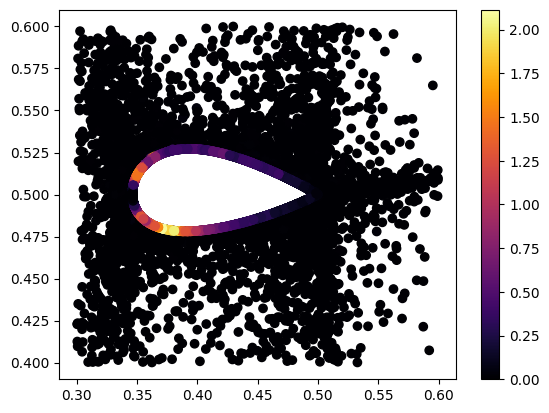

In [134]:
x_mask = (coord_plt[..., 0] < 0.6) & (coord_plt[..., 0] > 0.3)
y_mask = (coord_plt[..., 1] < 0.6) & (coord_plt[..., 1] > 0.4)
plot_mask = x_mask & y_mask
plt.scatter(coord_plt[plot_mask, 0], coord_plt[plot_mask, 1], c=((pred_plt*gamma-img_plt)**2)[plot_mask], cmap="inferno")
plt.colorbar()

In [184]:
from sklearn.cluster import KMeans

In [187]:
clustering_model = KMeans(n_clusters=128, init='k-means++', n_init='warn', max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='lloyd')

In [ ]:
clustering_model.fit(gr